In [11]:
import numpy as np
import json
from pathlib import Path

figpath = Path("/Users/yangjunjie/Downloads")

import matplotlib
import matplotlib.pyplot as plt
# use latex globally
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

data = None
with open('../data/diamond.json', 'r') as f:
    data = json.load(f)

basis = []
nkpt = []
kecut = []
for d in data:
    basis.append(data[d].get('basis', ''))
    nkpt.append(int(data[d].get('nkpt', 0)))
    ke_cutoff = data[d].get('ke_cutoff', 0)
    if ke_cutoff != 'None':
        kecut.append(float(ke_cutoff))

basis_list = list(set(basis))
nkpt_list = list(set(nkpt))
kecut_list = list(set(kecut))

nkpt_list.sort()
kecut_list.sort()

print(basis_list)
print(nkpt_list)
print(kecut_list)


['gth-szv', 'gth-dzvp']
[8, 16, 32, 64, 128, 256, 512]
[50.0, 100.0, 200.0, 400.0]


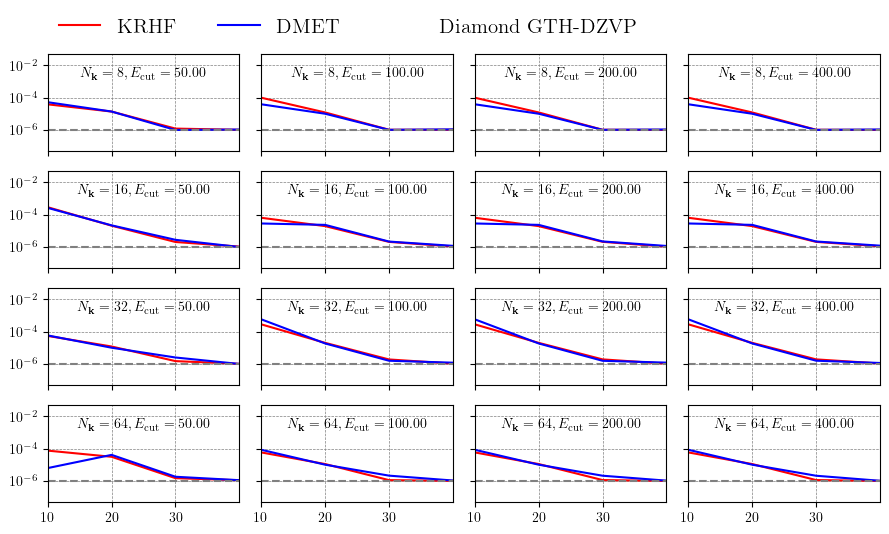

In [12]:
def plot_error(basis, nkpt, kecut):
    b = basis

    nx = len(nkpt)
    ny = len(kecut)
    fig, ax = plt.subplots(nx, ny, figsize=(9, 5), sharex=True, sharey=True)
    color = {'krhf': 'r', 'dmet': 'b'}
    for i, n in enumerate(nkpt):
        ene_krhf_ref = None
        ene_dmet_ref = None
        ene_krhf_gdf = None
        ene_dmet_gdf = None

        for d in data:
            if data[d].get('basis') == b and int(data[d].get('nkpt')) == n:
                if data[d].get('method') == 'fftdf' and data[d].get('ke_cutoff') == 400.0:
                    ene_krhf_ref = data[d].get('ene_krhf')
                    ene_dmet_ref = data[d].get('ene_dmet')
                elif data[d].get('method') == 'gdf':
                    ene_krhf_gdf = data[d].get('ene_krhf')
                    ene_dmet_gdf = data[d].get('ene_dmet')

        # print("ene_krhf_ref = % 12.8f" % ene_krhf_ref)
        # print("ene_dmet_ref = % 12.8f" % ene_dmet_ref)
        # print("ene_krhf_gdf = % 12.8f" % ene_krhf_gdf)
        # print("ene_dmet_gdf = % 12.8f" % ene_dmet_gdf)
        for j, k in enumerate(kecut):
            y1 = {"krhf": {}, "dmet": {}}
            y0 = {}
            yy = {}
            for d in data:
                ke_cutoff = data[d].get('ke_cutoff', 0)
                if ke_cutoff == 'None':
                    continue

                is_matched = ke_cutoff == k and data[d].get('basis') == b and int(data[d].get('nkpt')) == n
                if is_matched:
                    method = data[d].get('method', '')
                    if method == 'fftdf':
                        y0["krhf"] = data[d].get('ene_krhf')
                        y0["dmet"] = data[d].get('ene_dmet')
                    elif method == 'fftisdf':
                        yy["krhf"] = data[d].get('ene_krhf')
                        yy["dmet"] = data[d].get('ene_dmet')
                    elif 'fftisdf' in method and len(method.split('-')) == 2:
                        c = method.split('-')[1]
                        c = int(c)
                        y1["krhf"][c] = data[d].get('ene_krhf')
                        y1["dmet"][c] = data[d].get('ene_dmet')

            if len(y0) == 0:
                continue

            for key in y0.keys():
                x = y1[key].keys()
                x = list(x)
                x.sort()
                y1[key] = np.array([y1[key][c] for c in x])
                y0[key] = y0[key]

                y = abs(y1[key] - y0[key]) + 1e-6
                label = key.upper() if key == 'krhf' else "DMET"
                ax[i, j].semilogy(x, y, label=label, color=color[key], linestyle='-')

                if key in yy:
                    y = [abs(yy[key] - y0[key]) + 1e-6] * len(x)
                    ax[i, j].semilogy(x, y, color=color[key], linestyle='--')

            # ax[i, j].set_title(f'nkpt={n}, kecut={k}')
            ax[i, j].set_xlim(10, 40)
            ax[i, j].set_ylim(5e-8, 5e-2)
            ax[i, j].axhline(y=1e-6, color='gray', linestyle='--')
            ax[i, j].text(0.5, 0.8, r'$N_{\mathbf{k}}= %d, E_{\mathrm{cut}}= %6.2f$' % (n, k), ha='center', va='center', transform=ax[i, j].transAxes)
            ax[i, j].grid(
                which='both',
                axis='both',
                linestyle='--',
                linewidth=0.5,
                color='gray'
            )
            ax[i, j].set_xticks([10, 20, 30,])
    # make legend for all the subplots
    ax[0, 0].plot([], [], label=b.upper(), linestyle='', color='gray')
    lines = [ax[0, 0].lines[0], ax[0, 0].lines[1], ax[0, 0].lines[3]]
    fig.legend(
        lines,
        ['KRHF', 'DMET', 'Diamond ' + b.upper()],
        loc='upper left',
        bbox_to_anchor=(0.05, 1.08),
        ncol=3,
        fontsize=15,
        frameon=False
    )

    fig.tight_layout()
    plt.show()
    return fig, ax

fig, ax = plot_error("gth-dzvp", nkpt_list[:4], kecut_list)
fig.savefig(figpath / "diamond-gth-dzvp-err1.png", dpi=300, bbox_inches='tight')


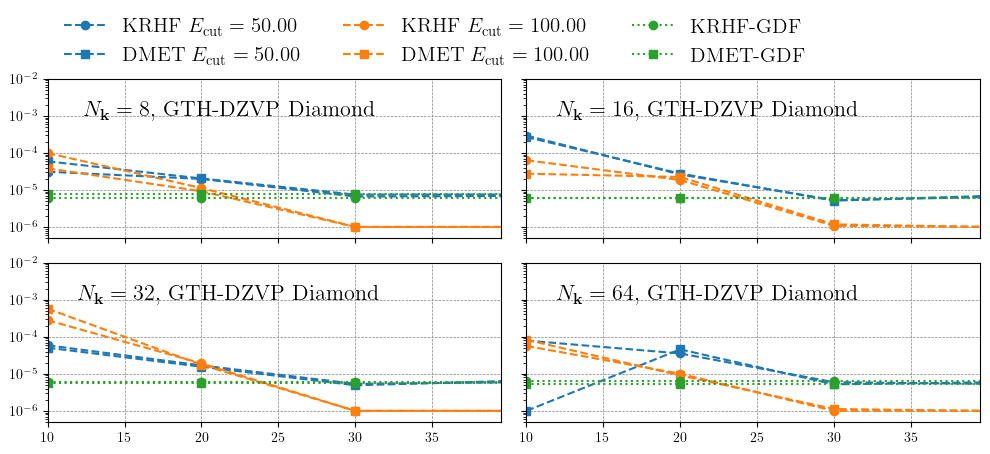

In [13]:
def plot_error_with_ref(basis, nkpt):
    b = basis

    nx, ny = 2, len(nkpt) // 2
    fig, ax = plt.subplots(nx, ny, figsize=(10, 4), sharex=True, sharey=True)

    for ik, n in enumerate(nkpt):
        ix = ik // ny
        iy = ik % ny
    
        ene_krhf_ref = np.nan
        ene_dmet_ref = np.nan
        ene_krhf_gdf = np.nan
        ene_dmet_gdf = np.nan
        
        cc = []
        kk = []
        
        for d in data:
            if data[d].get('basis') == b and int(data[d].get('nkpt')) == n:
                if data[d].get('method') == 'fftdf' and data[d].get('ke_cutoff') == 400.0:
                    ene_krhf_ref = data[d].get('ene_krhf')
                    ene_dmet_ref = data[d].get('ene_dmet')
                elif data[d].get('method') == 'gdf':
                    ene_krhf_gdf = data[d].get('ene_krhf')
                    ene_dmet_gdf = data[d].get('ene_dmet')
            
            if 'fftisdf' in data[d].get('method'):
                cc.append(int(data[d].get('method').split('-')[1]))
                kk.append(data[d].get('ke_cutoff'))

        cc = list(set(cc))
        cc.sort()
        kk = list(set(kk))
        kk.sort()
        kk = [50.0, 100.0]

        color = {k: c for k, c in zip(kk, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])}
        color["gdf"] = 'tab:green'
        marker = {'krhf': 'o', 'dmet': 's'}

        e_krhf = {}
        e_dmet = {}

        for c in cc:
            for k in kk:
                for d in data:
                    if data[d].get('basis') == b and int(data[d].get('nkpt')) == n:
                        is_matched = 'fftisdf' in data[d].get('method') and data[d].get('method').split('-')[1] == str(c) and data[d].get('ke_cutoff') == k
                        if is_matched:
                            e_krhf[(c, k)] = data[d].get('ene_krhf')
                            e_dmet[(c, k)] = data[d].get('ene_dmet')

        for k in kk:
            yy = []
            for c in cc:
                y0 = ene_krhf_ref
                y1 = e_krhf.get((c, k), np.nan)
                yy.append(max(abs(y1 - y0), 1e-6))
            ax[ix, iy].semilogy(cc, yy, label=r'KRHF $E_{\mathrm{cut}}=%6.2f$' % k, color=color[k], marker=marker['krhf'], linestyle='--')
            
            yy = []
            for c in cc:
                y0 = ene_dmet_ref
                y1 = e_dmet.get((c, k), np.nan)
                yy.append(max(abs(y1 - y0), 1e-6))
            ax[ix, iy].semilogy(cc, yy, label=r'DMET $E_{\mathrm{cut}}=%6.2f$' % k, color=color[k], marker=marker['dmet'], linestyle='--')

        yy = [abs(ene_krhf_gdf - ene_krhf_ref) for c in cc]
        ax[ix, iy].plot(cc, yy, color=color["gdf"], marker=marker['krhf'], linestyle=':', label='KRHF-GDF')
        yy = [abs(ene_dmet_gdf - ene_dmet_ref) for c in cc]
        ax[ix, iy].plot(cc, yy, color=color["gdf"], marker=marker['dmet'], linestyle=':', label='DMET-GDF')
        ax[ix, iy].set_xlim(10, 39.5)
        ax[ix, iy].set_ylim(5e-7, 1e-2)
        ax[ix, iy].text(0.4, 0.8, r'$N_{\mathbf{k}}= %d$, %s Diamond' % (n, b.upper()), ha='center', va='center', transform=ax[ix, iy].transAxes, fontsize=16)
        ax[ix, iy].grid(
            which='major',
            axis='both',
            linestyle='--',
            linewidth=0.5,
            color='gray'
        )

    fig.legend(
        ax[0, 0].lines,
        [l.get_label() for l in ax[0, 0].lines if l.get_label() != ''],
        loc='upper left',
        bbox_to_anchor=(0.05, 1.15),
        ncol=3,
        fontsize=15,
        frameon=False
    )

    fig.tight_layout()
    plt.show()
    return fig, ax

fig, ax = plot_error_with_ref("gth-dzvp", nkpt_list[:4])
# include legend outside the plot
fig.savefig(figpath / "diamond-gth-dzvp-err2.png", dpi=300, bbox_inches='tight')

../benchmark/nio-afm/1-1-1/gth-dzvp-molopt-sr/gdf-1.4
../benchmark/nio-afm/1-1-1/gth-dzvp-molopt-sr/gdf-1.2
../benchmark/nio-afm/1-1-1/gth-dzvp-molopt-sr/gdf-1.8
../benchmark/nio-afm/1-1-1/gth-dzvp-molopt-sr/gdf-1.6
../benchmark/nio-afm/1-1-1/gth-dzvp-molopt-sr/gdf-2.0
../benchmark/nio-afm/1-1-1/gth-dzvp-molopt-sr/gdf-auto
['auto', '2.0', '1.8', '1.6', '1.4', '1.2'] [ 578.  840.  988. 1234. 1728. 1897.]


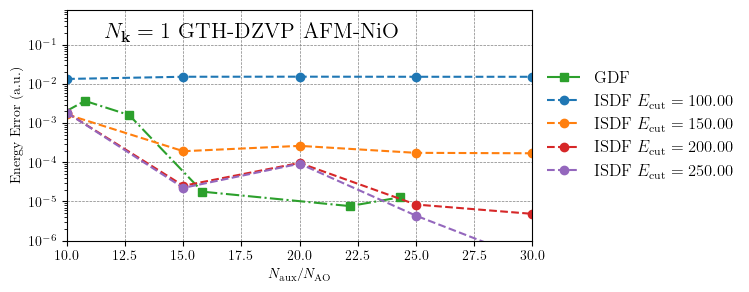

In [56]:
content = """
./gth-dzvp-molopt-sr/fftdf/100/slurm-49063182.out:610:Total Energy =                        -358.536234705509003
./gth-dzvp-molopt-sr/fftdf/200/slurm-49052115.out:575:Total Energy =                        -358.551575310963472
./gth-dzvp-molopt-sr/fftdf/400/slurm-49052116.out:575:Total Energy =                        -358.551578317201461
./gth-dzvp-molopt-sr/fftdf/50/slurm-49052114.out:750:Total Energy =                        -357.705728963957881
./gth-dzvp-molopt-sr/fftisdf-10/100/slurm-49063535.out:641:Total Energy =                        -358.538070025034244
./gth-dzvp-molopt-sr/fftisdf-10/150/slurm-49063536.out:641:Total Energy =                        -358.553248555185291
./gth-dzvp-molopt-sr/fftisdf-10/200/slurm-49063537.out:641:Total Energy =                        -358.553413331422007
./gth-dzvp-molopt-sr/fftisdf-10/400/slurm-49063538.out:641:Total Energy =                        -358.553416273938865
./gth-dzvp-molopt-sr/fftisdf-10/50/slurm-49063534.out:781:Total Energy =                        -357.707538656550014
./gth-dzvp-molopt-sr/fftisdf-20/100/slurm-49063540.out:641:Total Energy =                        -358.536141826223229
./gth-dzvp-molopt-sr/fftisdf-20/150/slurm-49063541.out:641:Total Energy =                        -358.551317775373832
./gth-dzvp-molopt-sr/fftisdf-20/200/slurm-49063542.out:641:Total Energy =                        -358.551482253498421
./gth-dzvp-molopt-sr/fftisdf-20/400/slurm-49063543.out:641:Total Energy =                        -358.551486148144249
./gth-dzvp-molopt-sr/fftisdf-20/50/slurm-49063539.out:746:Total Energy =                        -357.705731462024573
./gth-dzvp-molopt-sr/fftisdf-30/100/slurm-49063545.out:641:Total Energy =                        -358.536234175272227
./gth-dzvp-molopt-sr/fftisdf-30/150/slurm-49063546.out:641:Total Energy =                        -358.551409298130750
./gth-dzvp-molopt-sr/fftisdf-30/200/slurm-49063547.out:641:Total Energy =                        -358.551574707367934
./gth-dzvp-molopt-sr/fftisdf-30/400/slurm-49063548.out:641:Total Energy =                        -358.551576719013838
./gth-dzvp-molopt-sr/fftisdf-30/50/slurm-49063544.out:781:Total Energy =                        -357.705728150657137
./gth-dzvp-molopt-sr/fftisdf-40/100/slurm-49063550.out:641:Total Energy =                        -358.536234533650486
./gth-dzvp-molopt-sr/fftisdf-40/150/slurm-49063551.out:641:Total Energy =                        -358.551412045307870
./gth-dzvp-molopt-sr/fftisdf-40/200/slurm-49063552.out:641:Total Energy =                        -358.551574675560801
./gth-dzvp-molopt-sr/fftisdf-40/400/slurm-49063553.out:1026:Total Energy =                        -330.849704659557858
./gth-dzvp-molopt-sr/fftisdf-40/50/slurm-49063549.out:781:Total Energy =                        -357.705728786081522
./gth-dzvp-molopt-sr/gdf/slurm-49063179.out:574:Total Energy =                        -358.555289624404566
"""

data = {}
ene_krhf_ref = np.nan
ene_krhf_gdf = {}
ene_krhf_isdf = {}

data = None
with open('../data/nio-afm-dzvp.json', 'r') as f:
    data = json.load(f)

for p, d in data.items():
    if not '1-1-1' in p:
        continue

    if "fftisdf" in p:
        x = p.split('fftisdf-')[1].split('-')[0]
        k = int(x.split('/')[1])
        c = int(x.split('/')[0])
        e = d.get('ene_krhf')
        naux = d.get('naux')
        ene_krhf_isdf[(naux, k)] = e

    if "gdf" in p:
        print(p)
        beta = p.split('gdf-')[1]
        naux = d.get('naux')
        e = d.get('ene_krhf')
        ene_krhf_gdf[naux] = (beta, e)

    if "fftdf/400" in p:
        e = d.get('ene_krhf')
        ene_krhf_ref = e

kk = [100, 150, 200, 250, 300]
color = {k: c for k, c in zip(kk, ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])}
color["isdf"] = 'tab:blue'
color["gdf"] = 'tab:green'

ene_krhf_ref = -358.551578317201461

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

nao = 78
xx = list(ene_krhf_gdf.keys())
xx.sort()
xx = np.array(xx)
yy = [abs(ene_krhf_gdf[x][1] - ene_krhf_ref) for x in xx]
print([ene_krhf_gdf[x][0] for x in xx], xx)
ax.semilogy(xx / nao, yy, marker='s', linestyle='-.', label='GDF', color=color["gdf"])

for k in [100, 150, 200, 250]:
    xx = list(set([x[0] for x in ene_krhf_isdf.keys()]))
    xx.sort()

    xx = np.array(xx)
    yy = [abs(ene_krhf_isdf[(x, k)] - ene_krhf_ref) for x in xx]
    ax.semilogy(xx / nao, yy, marker='o', linestyle='--', label=r'ISDF $E_{\mathrm{cut}}=%6.2f$' % k, color=color[k])

ax.set_xlim(10, 30)
ax.set_ylim(1e-6, 8e-1)
ax.grid(which='major', linestyle='--', linewidth=0.5, color='gray')
ax.text(0.4, 0.9, r'$N_\mathbf{k}=1$ GTH-DZVP AFM-NiO', ha='center', va='center', transform=ax.transAxes, fontsize=16)
ax.set_xlabel(r'$N_{\mathrm{aux}}/N_{\mathrm{AO}}$')
ax.set_ylabel(r'Energy Error (a.u.)')

# put legend outside the plot on the right
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1,
    fontsize=12,
    frameon=False
)


fig.savefig(figpath / "diamond-gth-dzvp-err3.png", dpi=300, bbox_inches='tight')
